In [294]:
import numpy as np
import pandas as pd 
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer , TreebankWordTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import f1_score, accuracy_score , recall_score , precision_score
import pickle
from nltk.tokenize import word_tokenize, PunktSentenceTokenizer, TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer


In [295]:
#load Xtrain_tfidf from stored pickle 
with open('data/X_train_tfidf.pkl', 'rb') as input:
    X_train_tfidf = pickle.load(input)
    
with open('data/X_test_tfidf.pkl', 'rb') as input:
    X_test_tfidf = pickle.load(input)
    
with open('data/y_train_spacy.pkl', 'rb') as input:
    y_train = pickle.load(input)
    
with open('data/y_test_spacy.pkl', 'rb') as input:
    y_test = pickle.load(input)

### Create Confusion Matrix

In [296]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def plot_confusion_matrix(y_pred, y_true):
    '''Code stolen brazenly from sklearn example.'''
    cm = confusion_matrix(y_true, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, cmap = plt.get_cmap('Blues'), annot=True, ax = ax, fmt='g'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_ylabel('Predicted labels');ax.set_xlabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Fake', 'Real']); ax.yaxis.set_ticklabels(['Fake', 'Real']);


In [333]:
def print_model_scores(y_actual, y_predicted, model_name):
    accuracy = accuracy_score(y_actual, y_predicted) *  100 
    f1 = f1_score(y_actual, y_predicted) * 100
    precision = precision_score(y_actual, y_predicted) * 100
    recall = recall_score(y_actual, y_predicted) * 100
    print ("{} accuracy and F1 score \n".format(model_name))
    print ("Accuracy {:.5}".format(accuracy))
    print ("F1 {:.5}".format(f1))
    print ("Precision {:.5}".format(precision))
    print ("Recall {:.5}".format(recall))
    return [round(accuracy, 3), round(f1, 3), round(precision, 3), round(recall, 3)]
    

## Modeling

### Naive Bayes

In [298]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb = nb.fit(X_train_tfidf, y_train)
y_test_predict_nb = nb.predict(X_test_tfidf)

In [334]:
nb_scores = print_model_scores(y_test, y_test_predict_nb, "Naive Bayes")

Naive Bayes accuracy and F1 score 

Accuracy 81.971
F1 73.997
Precision 70.672
Recall 77.651


### Logistic Regression

In [300]:
# using optimal parameters from grid search (l1 and 10)
lr = LogisticRegression(penalty='l1', C = 10)
lr.fit(X_train_tfidf, y_train)
y_test_predict_lr = lr.predict(X_test_tfidf)

In [336]:
lr_scores = print_model_scores(y_test, y_test_predict_lr, "Logistic regression")

Logistic regression accuracy and F1 score 

Accuracy 89.32
F1 83.692
Precision 84.444
Recall 82.952


In [302]:
coeff = lr.coef_[0]
coeff.shape

(5000,)

In [303]:
top_n_index = np.argsort(coeff)[::-1][:20]
print(top_n_index)
with open('data/tfidf_featurename.pkl', 'rb') as input:
    featurenames_spacy = pickle.load(input)

    #feature_names = tfidf_vectorizer.get_feature_names()
top_feat_tuple = [(featurenames_spacy[i], coeff[i]) for i in top_n_index]

print(top_feat_tuple)

[2091 4408 3426  274  235 3132 1407  346 4974 3425  494  658 4843  967
 4279 1485 4692  974 3702 1684]
[('http', 30.396224575135378), ('subscribe org', 28.91444314221695), ('post appeared', 24.072483331264053), ('article', 23.53323333151819), ('appeared ordinal', 22.707282326388157), ('originally published', 21.245409094166526), ('embedded content', 21.073110567080974), ('average cardinal', 18.44892661266905), ('wrong', 16.544061423846383), ('post', 16.028087525804313), ('bullish', 15.804416364417987), ('certainly', 15.254171923884925), ('vs', 15.070716681571497), ('copyright', 14.90475274716434), ('spiritual', 14.828603742064852), ('essays', 14.800601814195739), ('ultimately', 14.487720245173747), ('correct', 14.049017506000395), ('reading', 13.724400088742959), ('figure', 13.650761712212933)]


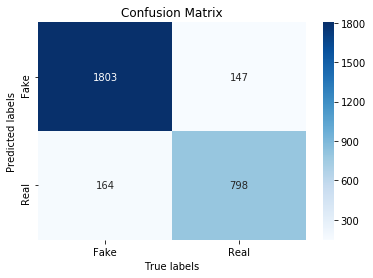

In [304]:
plot_confusion_matrix(y_test_predict_lr, y_test)


### Random Forest

In [305]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150, min_samples_split=5, max_depth=60)
rf.fit(X_train_tfidf, y_train)
y_test_predict_rf = rf.predict(X_test_tfidf)

In [337]:
rf_scores = print_model_scores(y_test, y_test_predict_rf, "Random Forest")

Random Forest accuracy and F1 score 

Accuracy 89.148
F1 82.405
Precision 88.729
Recall 76.923


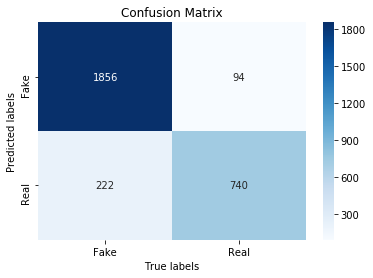

In [307]:
plot_confusion_matrix(y_test_predict_rf, y_test)

### SVM classifier

In [311]:
from sklearn.svm import SVC
svm = SVC(kernel = 'linear', probability = True, random_state = 0)

In [312]:
svm.fit(X_train_tfidf, y_train)
y_test_predict_svm = svm.predict(X_test_tfidf)

In [338]:
svm_scores = print_model_scores(y_test, y_test_predict_svm, "SVM")

SVM accuracy and F1 score 

Accuracy 88.908
F1 82.474
Precision 86.266
Recall 79.002


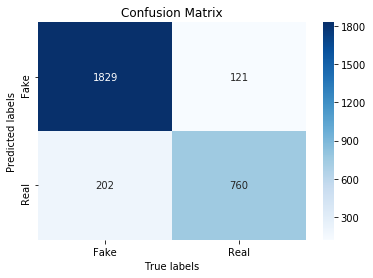

In [284]:
plot_confusion_matrix(y_test_predict_svm, y_test)

### Boosting using Adaboost

In [308]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(algorithm = "SAMME.R", n_estimators = 50)
ada.fit(X_train_tfidf, y_train)
y_test_predict_ada = ada.predict(X_test_tfidf)

In [339]:
ada_scores = print_model_scores(y_test, y_test_predict_ada, "AdaBoost")

AdaBoost accuracy and F1 score 

Accuracy 87.054
F1 80.736
Precision 79.397
Recall 82.121


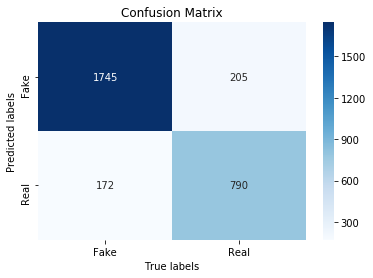

In [310]:
plot_confusion_matrix(y_test_predict_ada, y_test)

### Gradient Boosting

In [352]:
from sklearn.ensemble import GradientBoostingClassifier

In [353]:
gb = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 50, n_estimators = 100, subsample = 0.5)
gb.fit(X_train_tfidf, y_train)
y_test_predict_gb = gb.predict(X_test_tfidf)

In [356]:
gb_scores = print_model_scores(y_test, y_test_predict_gb, "Gradient Boosting")

Gradient Boosting accuracy and F1 score 

Accuracy 91.003
F1 85.929
Precision 88.889
Recall 83.16


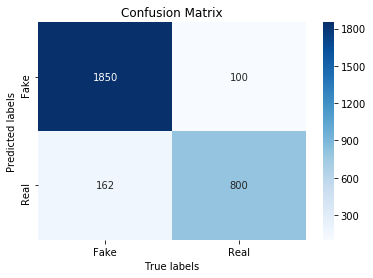

In [357]:
plot_confusion_matrix(y_test_predict_gb, y_test)

### Lets plot ROC curve for various models

In [360]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as skm
from sklearn.metrics import roc_curve, roc_auc_score
%matplotlib inline

In [361]:
# First calculate predicted probabilities for all the models
nb_probs = nb.predict_proba(X_test_tfidf)[:, 1]
lr_probs = lr.predict_proba(X_test_tfidf)[:, 1]
rf_probs = rf.predict_proba(X_test_tfidf)[:, 1]
ada_probs = ada.predict_proba(X_test_tfidf)[:, 1]
svm_probs = svm.predict_proba(X_test_tfidf)[:, 1]
gb_probs = gb.predict_proba(X_test_tfidf)[:, 1]

#fpr, tpr, threshold = roc_curve(y_test, preds)
fpr_nb, tpr_nb, thresholds_nb = skm.roc_curve(y_test, nb_probs)
fpr_lr, tpr_lr, thresholds_lr = skm.roc_curve(y_test, lr_probs)
fpr_rf, tpr_rf, thresholds_rf = skm.roc_curve(y_test, rf_probs)
fpr_ada, tpr_ada, thresholds_ada = skm.roc_curve(y_test, ada_probs)
fpr_svm, tpr_svm, thresholds_svm = skm.roc_curve(y_test, svm_probs)
fpr_gb, tpr_gb, thresholds_gb = skm.roc_curve(y_test, gb_probs)

In [362]:
import sklearn.metrics as skm
roc_auc_nb = skm.roc_auc_score(y_test, y_test_predict_nb)
roc_auc_lr = skm.roc_auc_score(y_test, y_test_predict_lr)
roc_auc_rf = skm.roc_auc_score(y_test, y_test_predict_rf)
roc_auc_ada = skm.roc_auc_score(y_test, y_test_predict_ada)
roc_auc_svm = skm.roc_auc_score(y_test, y_test_predict_svm)
roc_auc_gb = skm.roc_auc_score(y_test, y_test_predict_gb)

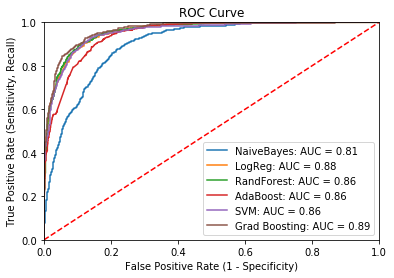

In [363]:
#Now plot these values
plt.title('ROC Curve')
plt.plot(fpr_nb, tpr_nb, label = 'NaiveBayes: AUC = %0.2f' % roc_auc_nb)
plt.plot(fpr_lr, tpr_lr, label = 'LogReg: AUC = %0.2f' % roc_auc_lr)
plt.plot(fpr_rf, tpr_rf, label = 'RandForest: AUC = %0.2f' % roc_auc_rf)
plt.plot(fpr_ada, tpr_ada, label = 'AdaBoost: AUC = %0.2f' % roc_auc_ada)
plt.plot(fpr_svm, tpr_svm, label = 'SVM: AUC = %0.2f' % roc_auc_svm)
plt.plot(fpr_gb, tpr_gb, label = 'Grad Boosting: AUC = %0.2f' % roc_auc_gb)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.show()

In [364]:
# Model Performance
column_names = ['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall']
data = [
        ['Naive Bayes'] + nb_scores,
        ['Logistic Regression'] + lr_scores,
        ['Random Forest'] + rf_scores,
        ['SVM'] + svm_scores,
        ['Adaboost'] + ada_scores,
        ['Gradient Boosting'] + gb_scores
       ]

model_perform = pd.DataFrame.from_records(data, columns=column_names)
model_perform

,Model,Accuracy,F1 Score,Precision,Recall
0,Naive Bayes,81.971,73.997,70.672,77.651
1,Logistic Regression,89.320,83.692,84.444,82.952
2,Random Forest,89.148,82.405,88.729,76.923
3,SVM,88.908,82.474,86.266,79.002
4,Adaboost,87.054,80.736,79.397,82.121
5,Gradient Boosting,91.003,85.929,88.889,83.160
